# Grid Optimization Analysis

In [1]:
import numpy as np
import qcportal as ptl
import matplotlib.cm
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, DrawingArea, TextArea
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from sklearn import decomposition # PCA
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Interactive plots
%matplotlib notebook

## Loading the Data

In [3]:
CLIENT = ptl.FractalClient()
DATASET = CLIENT.get_collection('GridOptimizationDataset',
                                'OpenFF Trivalent Nitrogen Set 1')
MOLECULE_IDS = [
    DATASET.get_entry(index).initial_molecule for index in DATASET.df.index
]
MOLECULES = CLIENT.query_molecules(id=MOLECULE_IDS)
METADATA_ENTRIES = [
    DATASET.get_entry(index).object_map['default'] for index in DATASET.df.index
]
# get all grid optimization calculations from the entire dataset
ENTRIES = CLIENT.query_procedures(METADATA_ENTRIES)

# Expected number of optimization frames
NUM_FRAMES = 21

# Remove molecules that have no optimizations
GOOD_MOLECULES = []
GOOD_ENTRIES = []
for idx, entry in enumerate(ENTRIES):
    final_energies = entry.get_final_energies()
    if len(final_energies) != NUM_FRAMES:
        print(f"Molecule {idx:3} ({MOLECULES[idx].get_molecular_formula()}) has {len(final_energies)} frames")
    else:
        GOOD_MOLECULES.append(MOLECULES[idx])
        GOOD_ENTRIES.append(ENTRIES[idx])

Molecule  66 (C22Cl2H24NO6PS) has 0 frames
Molecule  83 (C16H37NO2P2S2) has 0 frames
Molecule  84 (C22H24NO2PS) has 0 frames
Molecule  85 (C20H21N3O4S) has 0 frames
Molecule 138 (C4H6N2O) has 0 frames
Molecule 141 (C19H13NO3S) has 0 frames
Molecule 157 (C31H45N3O8S3) has 0 frames
Molecule 160 (C21H22N2O6S2) has 0 frames
Molecule 175 (C28H22NO2P) has 0 frames
Molecule 193 (C22H24N6O6S2) has 0 frames
Molecule 204 (C12H21N2P) has 0 frames
Molecule 218 (BrC9H8N3) has 0 frames
Molecule 236 (C6H5N3) has 0 frames
Molecule 242 (C13H18N3O2) has 0 frames
Molecule 252 (C24H20NOP) has 0 frames
Molecule 277 (C12H11N2O3S) has 0 frames
Molecule 279 (C10H8N2O2) has 0 frames
Molecule 286 (C7H4INO3S) has 0 frames
Molecule 298 (C22H30N3P) has 0 frames


In [4]:
print(f"There are {len(GOOD_MOLECULES)} good molecules.")

There are 292 good molecules.


## Visualization

Get a better idea of what the data looks like using PCA.

In [5]:
# Create vectors of the energies
ENERGIES = np.zeros(shape=(len(GOOD_ENTRIES), NUM_FRAMES))

for idx, entry in enumerate(GOOD_ENTRIES):
    final_energies = entry.get_final_energies()
    for frame_idx in range(NUM_FRAMES):
        ENERGIES[idx][frame_idx] = final_energies[(frame_idx,)]
    # Normalize the energies by subtracting the minimum energy
    min_energy = np.min(ENERGIES[idx])
    ENERGIES[idx] -= min_energy

# Apply PCA to reduce to 2d for plotting
pca_2d = decomposition.PCA(n_components=2)
ENERGIES_2D = pca_2d.fit_transform(ENERGIES)

In [11]:
def pca_plot(clusters=None):
    """Create a plot of the PCA.
    
    When one hovers over the points, they can see the normalized 1D
    scan for it, as well as the index and molecular formula.
    |clusters| is an array such that clusters[i] is the cluster id
    of molcule i.
    """
    if clusters is None:
        clusters = np.zeros(len(GOOD_ENTRIES))
    fig, ax = plt.subplots(1,2,figsize=(10, 4))
    pca_ax = ax[0]  # Scatterplot of the energies after 2D PCA
    scan_ax = ax[1] # 1D scan of molecule energies
    
    scatter_path = pca_ax.scatter(ENERGIES_2D[:,0],
                                  ENERGIES_2D[:,1],
                                  c=clusters,
                                  cmap=matplotlib.cm.get_cmap("tab20c"))
    pca_ax.set_title("2D PCA of Molecule Energies")

    def show_plot(event):
        """
        A callback that handles mouse events and shows the molecule
        in the plot.
        """
        mouse_hovering, info = scatter_path.contains(event)
        if mouse_hovering:
            # Index within the array where the event occurred.
            ind, = info["ind"]

            # Set the 1D scan plot to correspond to the point.
            scan_ax.clear()
            scan_ax.plot(np.arange(0,NUM_FRAMES,1), ENERGIES[ind])
            scan_ax.set_title(f"Molecule {ind} | {GOOD_MOLECULES[ind].get_molecular_formula()}")
            scan_ax.set_xticks(np.arange(0,NUM_FRAMES,2))
        fig.canvas.draw_idle()
    # Add the callback.
    fig.canvas.mpl_connect('motion_notify_event', show_plot)

    plt.show()

<IPython.core.display.Javascript object>


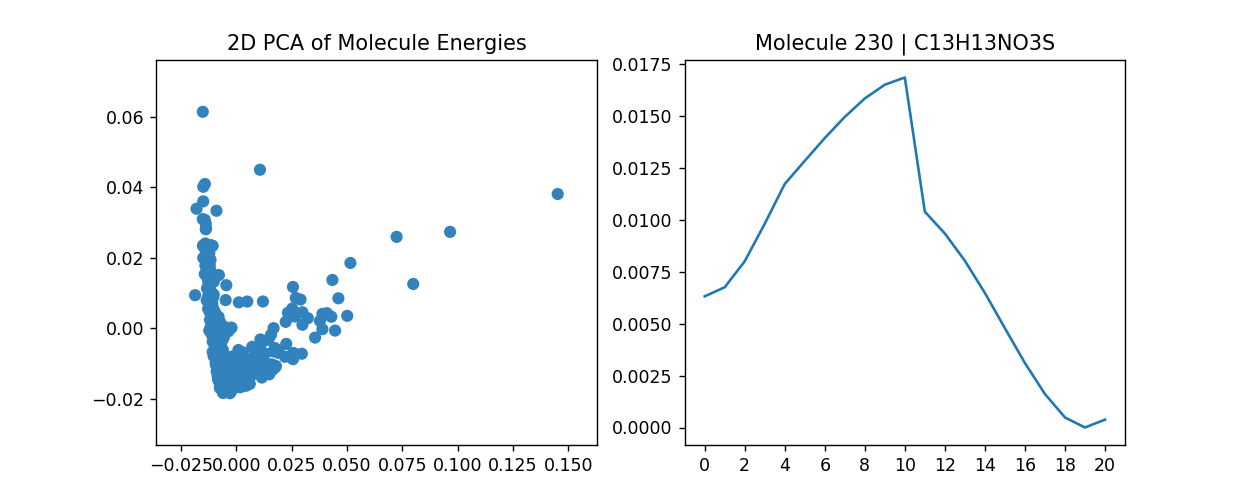

In [12]:
# Rerun if interactivity not working
pca_plot()

## Clustering
Clustering the molecules by energy profile.

<IPython.core.display.Javascript object>


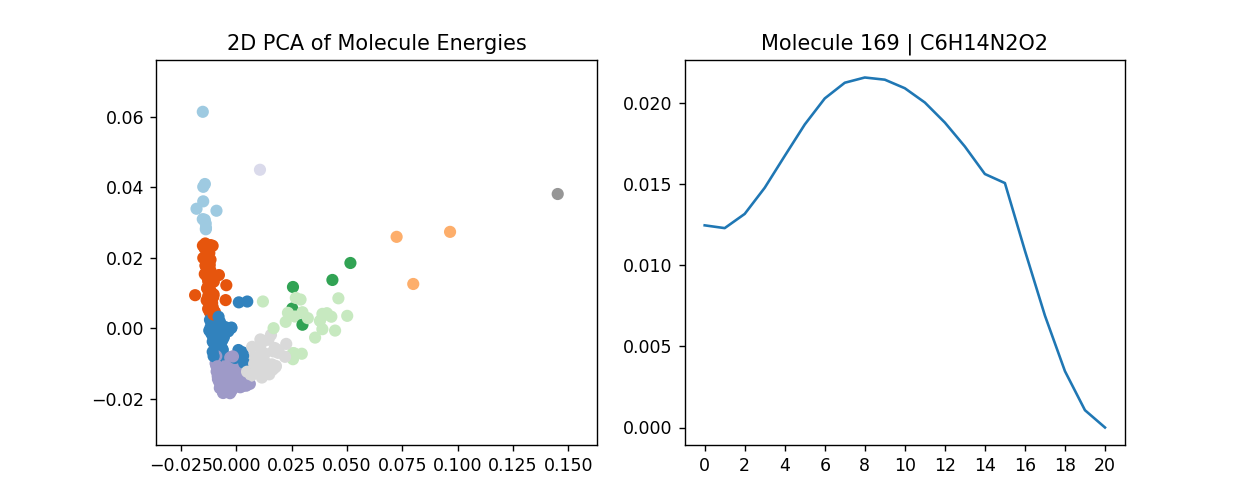

In [13]:
clusters = AgglomerativeClustering(n_clusters=10,
                                   affinity="euclidean",
                                   linkage="ward").fit_predict(ENERGIES)
pca_plot(clusters)